In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import sys
import os
from multiprocessing import Pool
from functools import partial
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import numpy as np
from dask.distributed import Client, progress, LocalCluster
from dask import compute, delayed
import dask.array as da
from dask.diagnostics import ProgressBar
plt.rcParams['figure.dpi']=400

# Problem 4.1

### Hamiltonian

In [55]:
def denseH(L, J, hx, hz, periodic):
    """
    generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim)) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx # contribution by sigma^j_x
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   

def diagonalize(L, J, hx, hz, periodic):
    
    H = denseH(L, J, hx, hz, periodic)
    
    return scipy.linalg.eigh(H)

# Problem 4.1.1

In [60]:
J = 1
hx = -1.05
hz = 0.5
periodic = True

print(denseH(2, J, hx, hz, periodic))
print(diagonalize(2, J, hx, hz, periodic)[0])
print(diagonalize(2, J, hx, hz, periodic)[1])

[[-3.    1.05  1.05  0.  ]
 [ 1.05  2.    0.    1.05]
 [ 1.05  0.    2.    1.05]
 [ 0.    1.05  1.05 -1.  ]]
[-3.48026209 -1.45214949  2.          2.93241158]
[[ 0.93572522 -0.26913596  0.         -0.22800035]
 [-0.21399683 -0.19837249 -0.70710678 -0.64409139]
 [-0.21399683 -0.19837249  0.70710678 -0.64409139]
 [ 0.18118785  0.92133737  0.         -0.3439599 ]]


### Translation-invariant product state wave function

In [61]:
eps = np.array([[1/2],[-np.sqrt(3)/2]])

def psi_initial(L):

    psi_0 = eps
    for _ in range(1, L):
        psi_0 = np.kron(psi_0, eps)
    
    return psi_0
print(psi_initial(2))


[[ 0.25     ]
 [-0.4330127]
 [-0.4330127]
 [ 0.75     ]]


In [152]:
vecs=diagonalize(2, J, hx, hz, periodic)[1]
print(vecs)
vec1=vecs[:, 0]
vec2=vecs[:, 1]
# print(vec1)
Sy=np.kron([[1, 0],[0, 1]], [[0, -1j],[1j, 0]])
print(Sy @ vec1)
print(np.array([ 0.93572522, -0.21399683, -0.21399683,  0.18118785]))
Sv = np.array([ 0.21399683j , 0.93572522j, -0.18118785j,  -0.21399683j])

print(vec2.T @ Sv.T)

print('----')
print(sigma('y', vecs)[:, 0])
print(sigma('y', vecs)[:, 1])
print(sigma('y', vecs)[:, 2])



[[ 0.93572522 -0.26913596  0.         -0.22800035]
 [-0.21399683 -0.19837249 -0.70710678 -0.64409139]
 [-0.21399683 -0.19837249  0.70710678 -0.64409139]
 [ 0.18118785  0.92133737  0.         -0.3439599 ]]
[0.+0.21399683j 0.+0.93572522j 0.-0.18118785j 0.-0.21399683j]
[ 0.93572522 -0.21399683 -0.21399683  0.18118785]
-0.40443697344358254j
----
[0.+7.19748384e-18j 0.-4.04436973e-01j 0.-7.89776799e-01j
 0.-4.61176043e-01j]
[0.+4.04436973e-01j 0.+1.06460556e-17j 0.-4.61176043e-01j
 0.+7.89776799e-01j]
[0.+0.7897768j  0.+0.46117604j 0.+0.j         0.-0.40443697j]


In [190]:
def sigma(mu, vecs):
    
    N = len(vecs)
    
    sigma_vecs = np.zeros((len(vecs[0]), N), dtype = complex)  # Initialize sigma_vecs as a 2D numpy array
    
    for i in range(N):
        
        vec = vecs[:, i]

        for alpha in range(len(vec)):
        
            if mu == 'z':
                if alpha & 1 :  # checking if spin-1 is down
                    sigma_vecs[alpha, i] -= vec[alpha]
                else:
                    sigma_vecs[alpha, i] = vec[alpha]
                    
            elif mu == 'y':
                beta = alpha ^ 1 
                
                if alpha & 1:
                    sigma_vecs[beta, i] = -1j * vec[alpha]
                else:
                    sigma_vecs[beta, i] = 1j * vec[alpha]

            elif mu == 'x':
                beta = alpha ^ (1 << 0)
                sigma_vecs[beta, i] = vec[alpha]

    sigma_matrix = np.conj(vecs).T @ sigma_vecs
    
    return sigma_matrix

def expectation_value(sigma_matrix, eigs, coeffs, t):

    total = 0
    N = len(coeffs)
    
    for m in range(N):
        for n in range(N):
            phase_factor = np.exp(-1j * (eigs[n] - eigs[m]) * t)
            total += np.conj(coeffs[m]) * coeffs[n] * phase_factor * sigma_matrix[m, n]
    
    return np.real(total)

def expectation_value_efficient(sigma_matrix, eigs, coeffs, t):

    delta_eigs = eigs[:, np.newaxis] - eigs[np.newaxis, :]
    
    phase_factors = np.exp(-1j * delta_eigs * t)
    
    coeff_matrix = np.outer(np.conj(coeffs), coeffs)
    
    total_matrix = coeff_matrix * phase_factors * sigma_matrix
    
    return np.real(np.sum(total_matrix))

In [189]:
L = 8
eigs, vecs = diagonalize(L, J, hx, hz, periodic)
psi = psi_initial(L)
coeffs = vecs.conj().T @ psi

sigma_matrix = sigma('x', vecs)
t_values = np.linspace(0, 1, 40)

for t in t_values:
    print(expectation_value(sigma_matrix, eigs, coeffs, t)-expectation_value_efficient(sigma_matrix, eigs, coeffs, t))

[-7.77156117e-16]
[1.99840144e-15]
[7.77156117e-16]
[1.11022302e-16]
[1.22124533e-15]
[-2.22044605e-16]
[2.77555756e-15]
[-9.99200722e-16]
[1.11022302e-15]
[1.99840144e-15]
[-1.77635684e-15]
[1.55431223e-15]
[-9.99200722e-16]
[1.55431223e-15]
[-1.55431223e-15]
[1.33226763e-15]
[5.55111512e-16]
[9.99200722e-16]
[7.77156117e-16]
[-2.22044605e-16]
[-1.22124533e-15]
[1.55431223e-15]
[5.55111512e-16]


KeyboardInterrupt: 

Processing L=6:   0%|          | 0/20 [00:00<?, ?it/s]

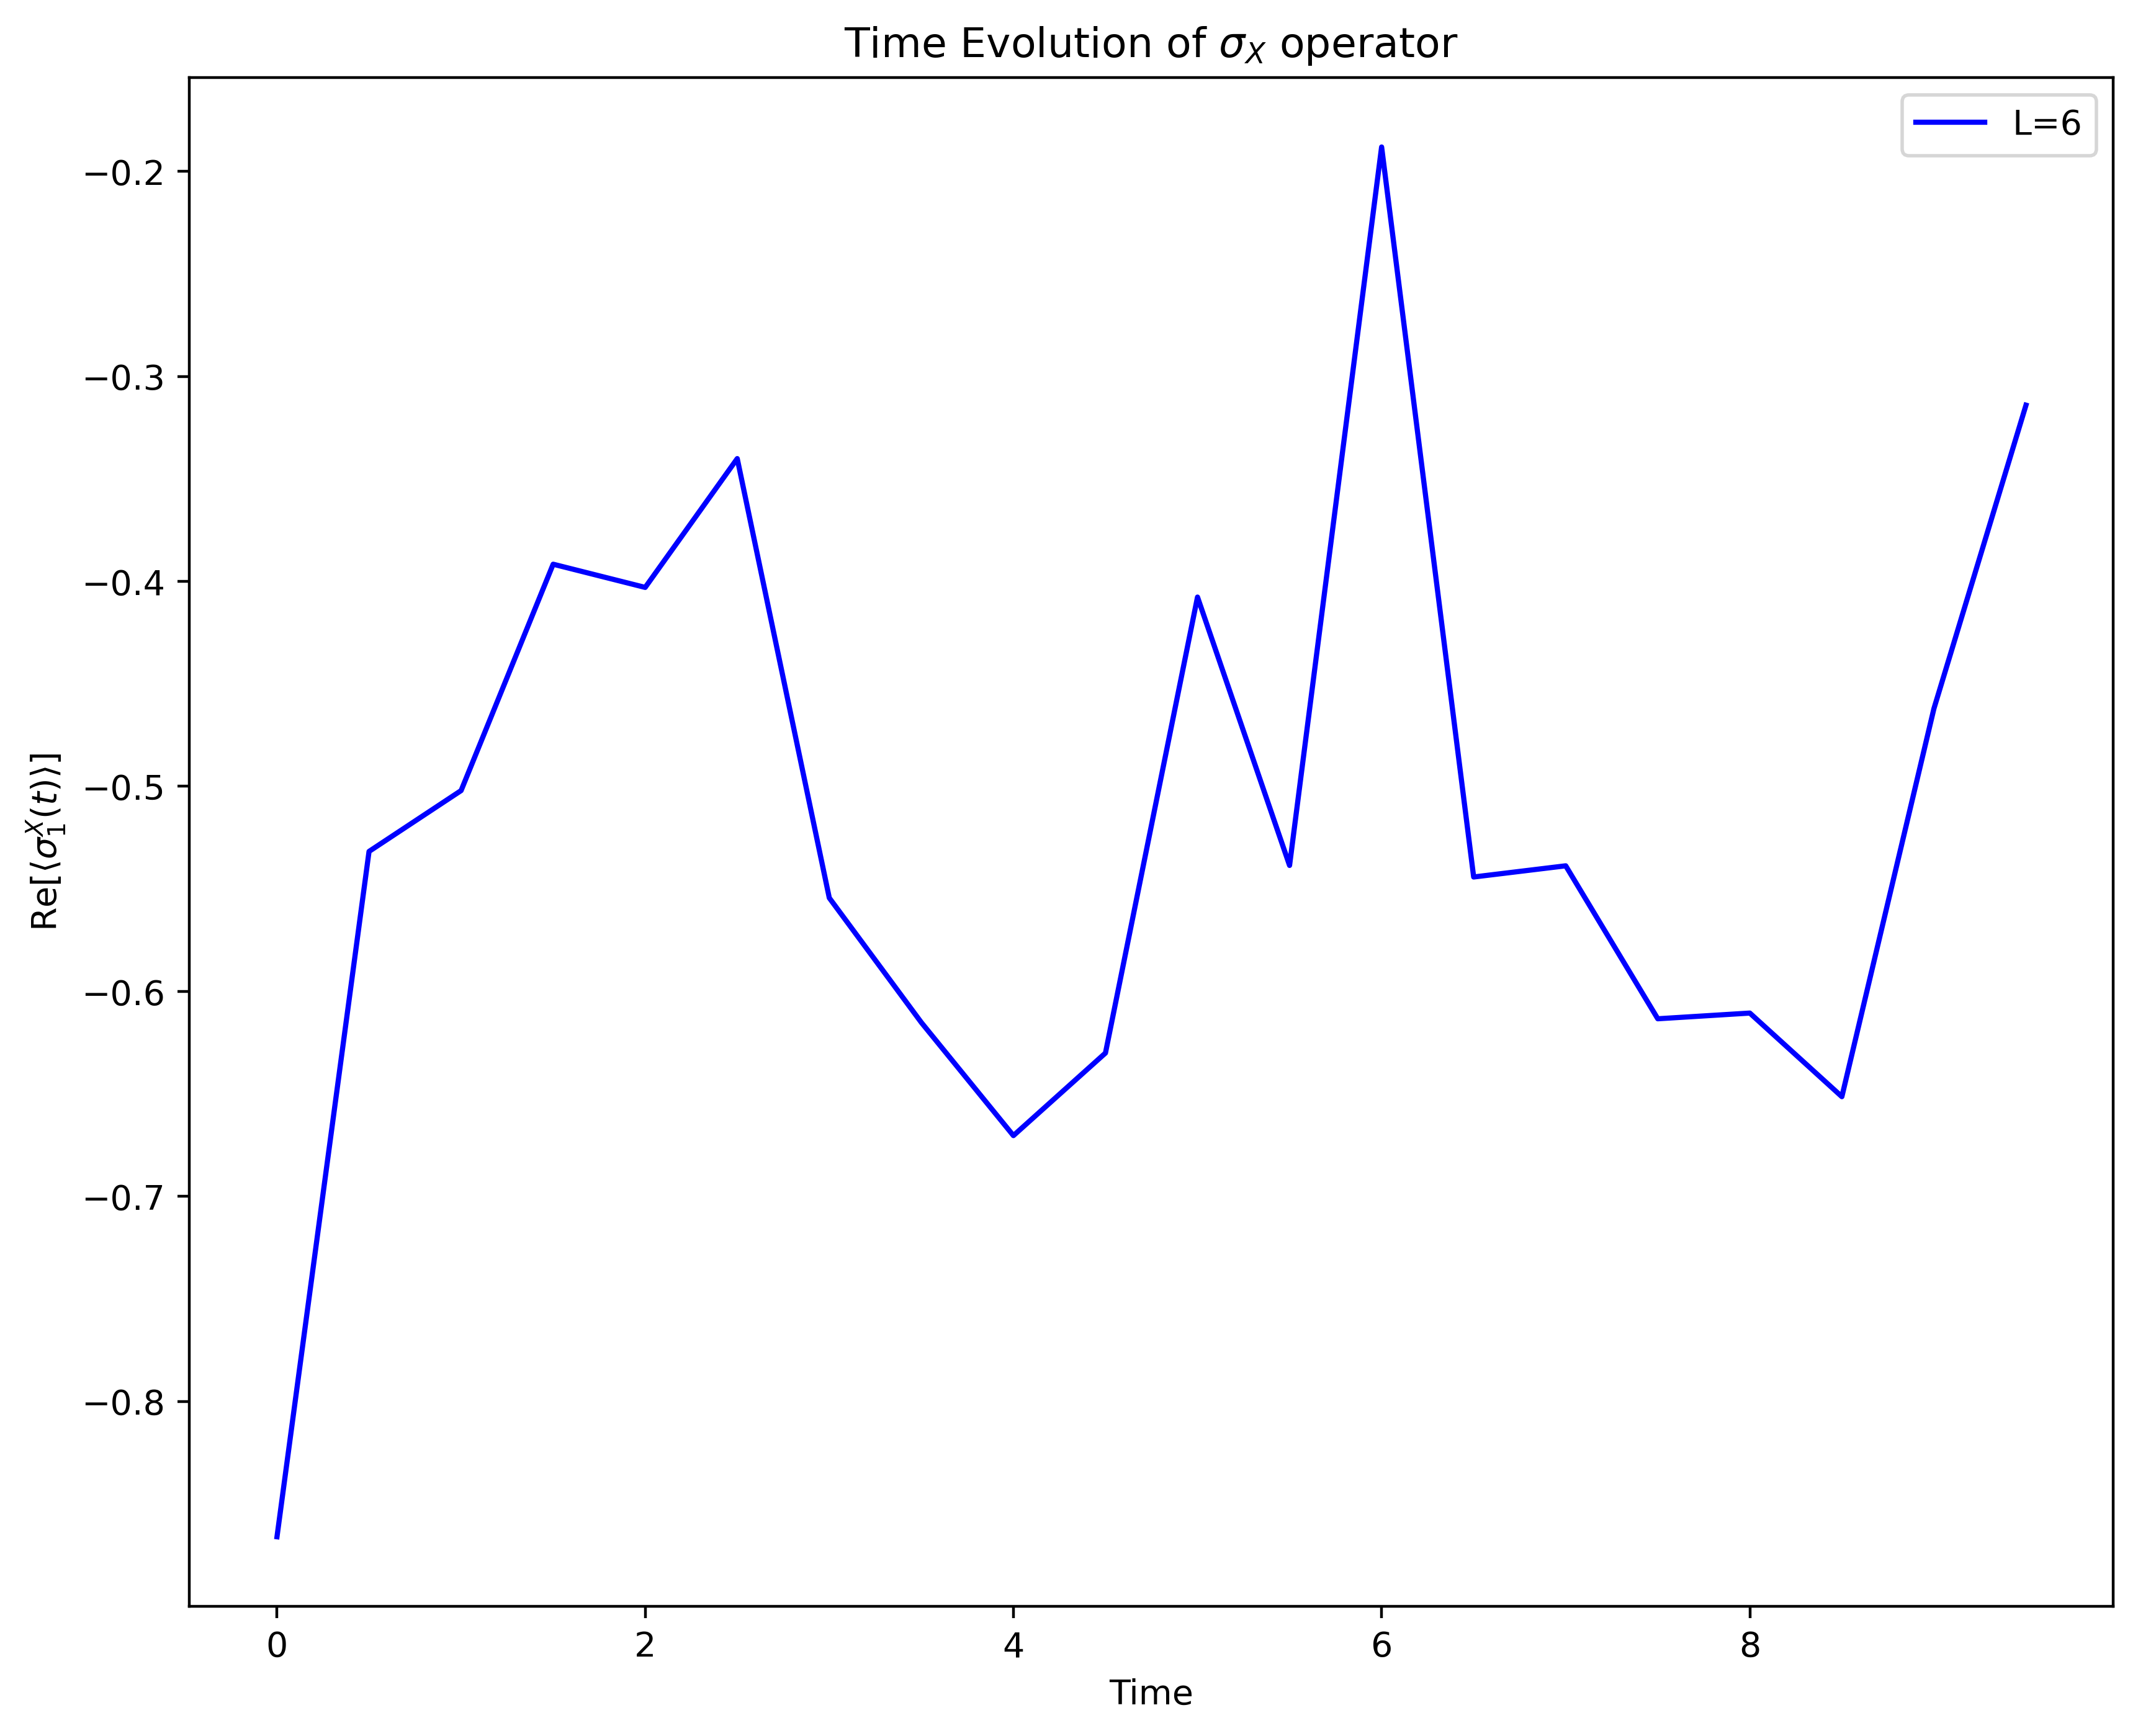

In [177]:
# equilibrium_values = {6: 0.17446143712005047, 8: 0.10421764864766271, 10: 0.07173501883214486, 12: 0.04167079901350792}

dt = 0.05
T = np.arange(0, 10, 0.5)

plt.figure(figsize=(10, 8))

colors = ['b', 'g', 'r', 'xkcd:black']
color_index = 0

for L in [6]:
    eigs, vecs = diagonalize(L, J, hx, hz, periodic)
    psi = psi_initial(L)
    coeffs = vecs.conj().T @ psi
    sigma_matrix = sigma('x', vecs)

    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))

    # Plot the time evolution
    plt.plot(T, Yarray, label=f'L={L}', color=colors[color_index])

    # Draw horizontal line for the equilibrium thermal state
    # plt.axhline(y=equilibrium_values[L], color=colors[color_index], linestyle='--', label=f'Eq. Thermal State for L={L}')

    color_index += 1

plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^X (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_X$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmax.png'), dpi=400)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


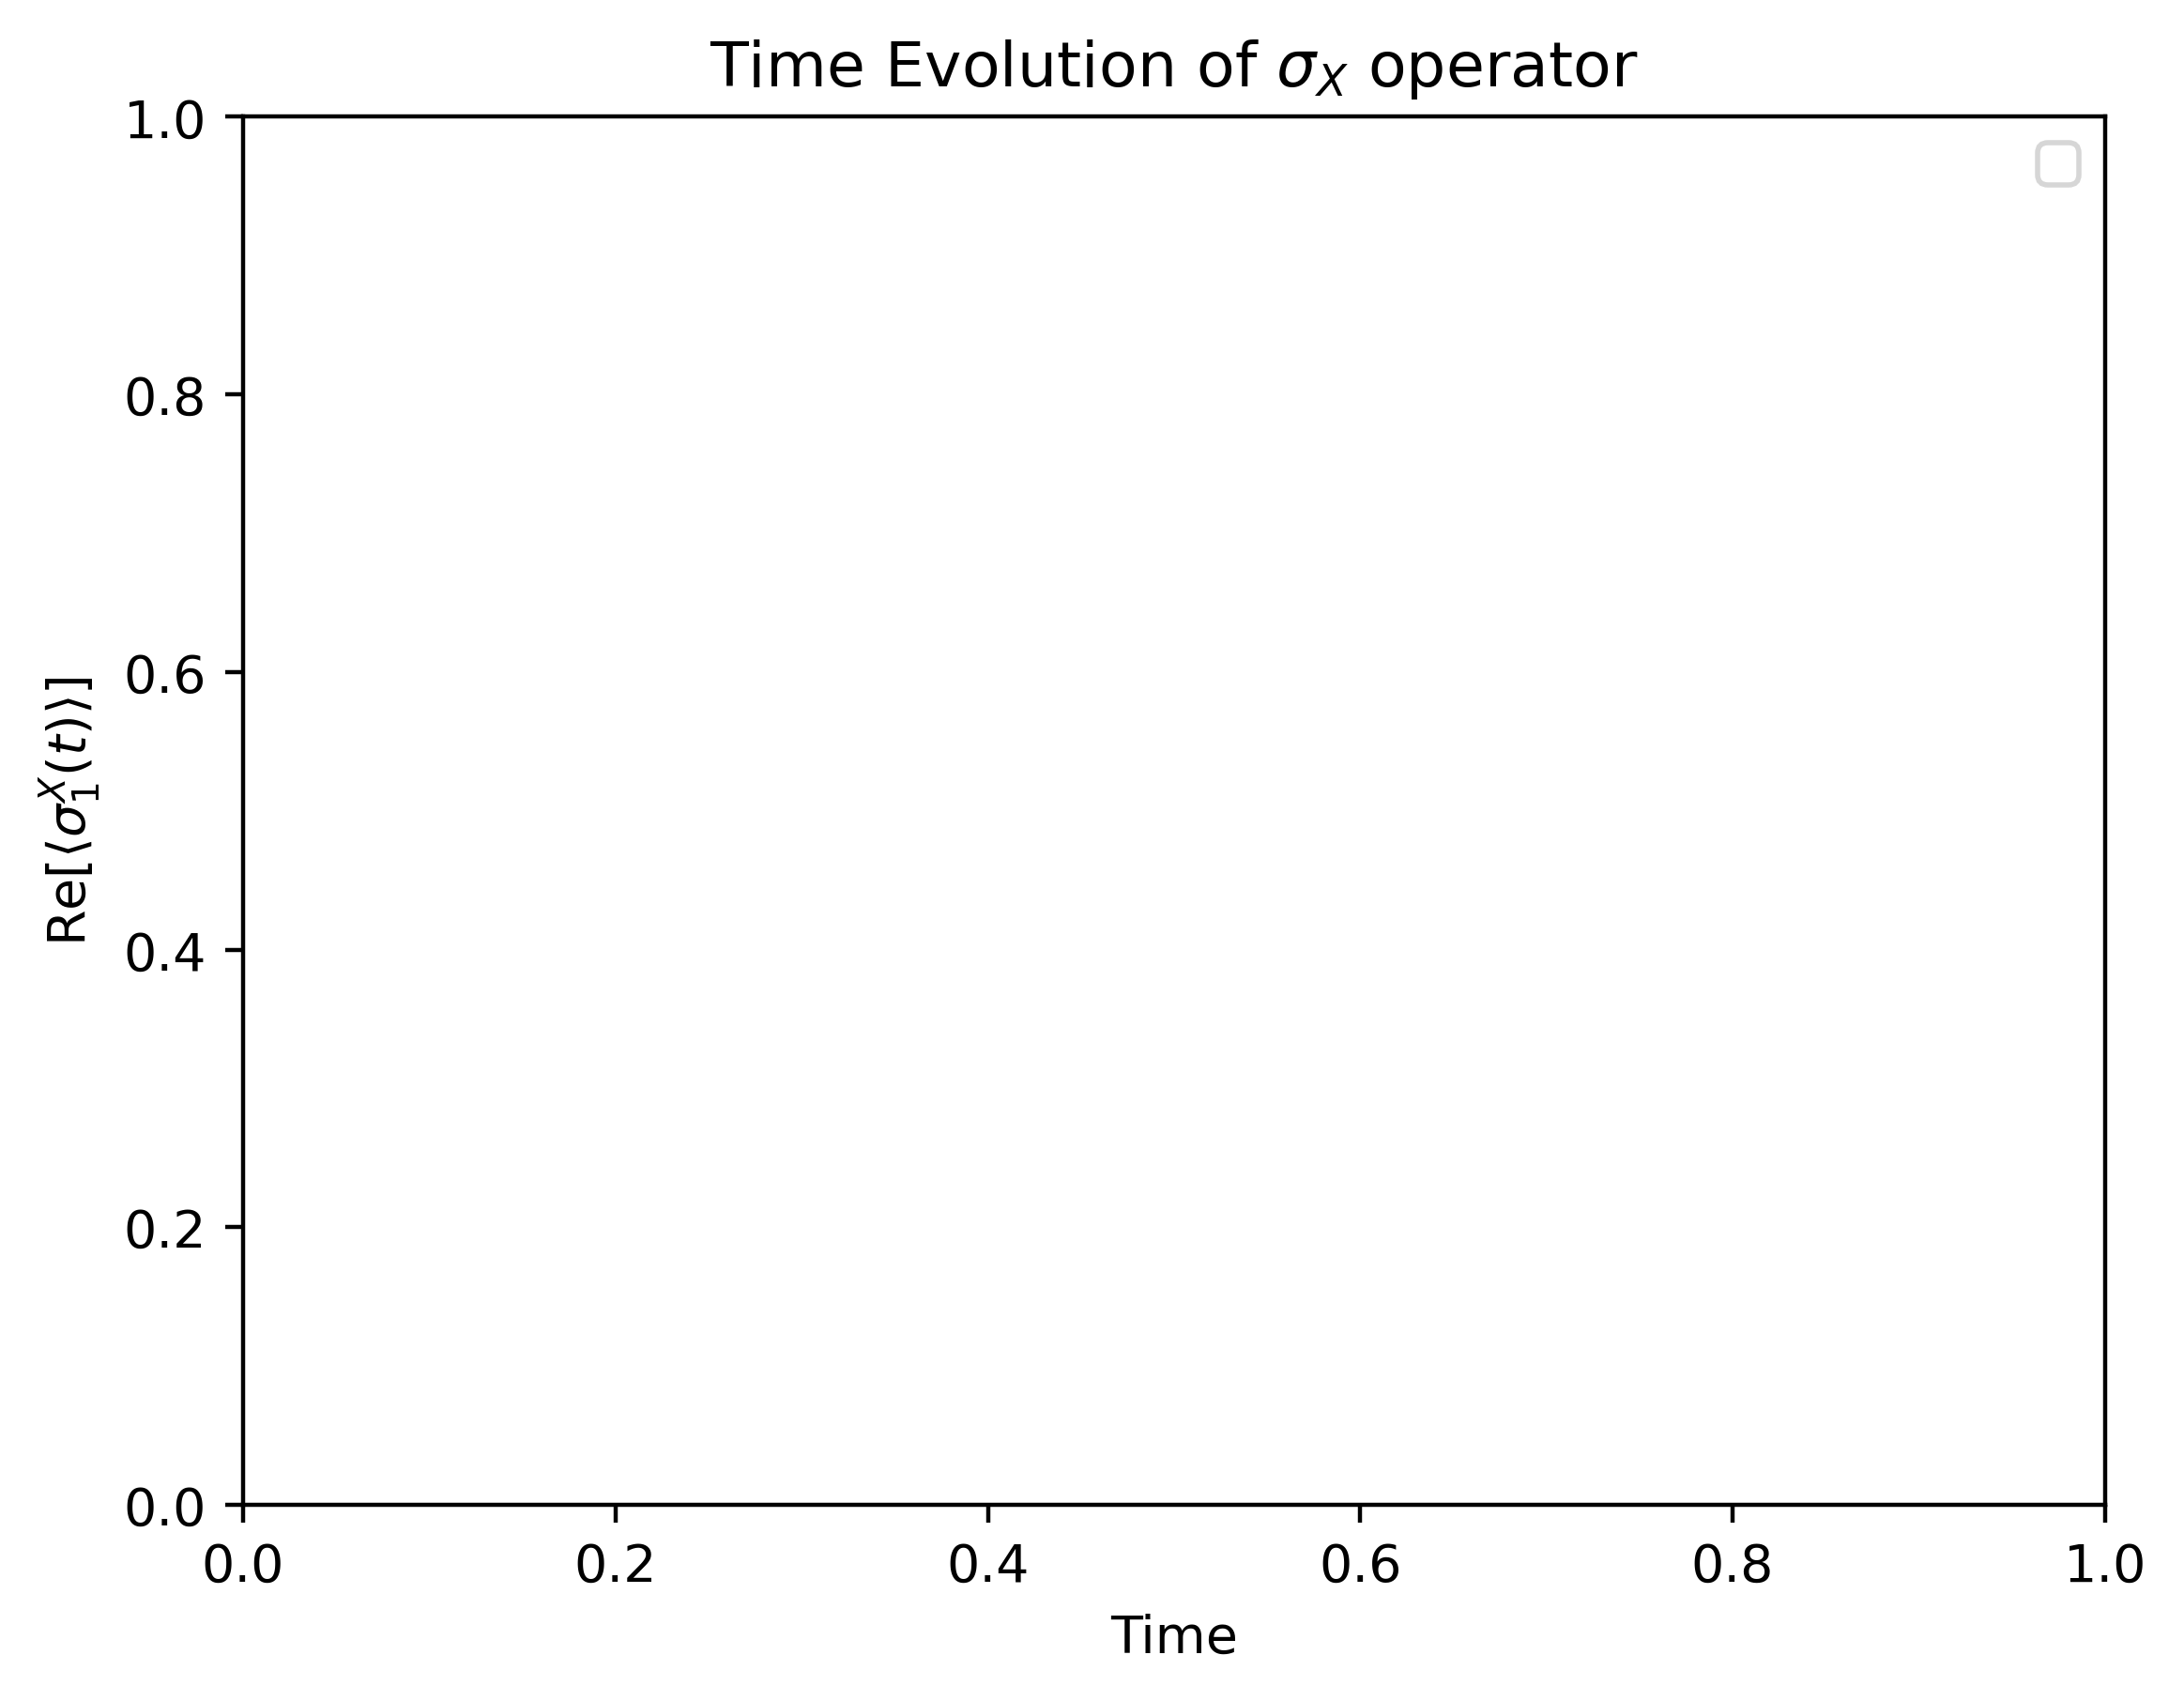

In [66]:
equilibrium_values = {6: 0.17446143712005047, 8: 0.10421764864766271, 10: 0.07173501883214486, 12: 0.04167079901350792}

dt = 0.05
T = np.arange(0, 10, dt)

plt.figure(figsize=(10, 8))

colors = ['b', 'g', 'r', 'c']
color_index = 0

for L in [6, 8, 10, 12]:
    eigs, vecs = diagonalize(L, J, hx, hz, periodic)
    psi = psi_initial(L)
    coeffs = np.dot(vecs, psi).squeeze()
    sigma_matrix = sigma('x', vecs)

    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))

    # Plot the time evolution
    plt.plot(T, Yarray, label=f'L={L}', color=colors[color_index])

    # Draw horizontal line for the equilibrium thermal state
    plt.axhline(y=equilibrium_values[L], color=colors[color_index], linestyle='--', label=f'Eq. Thermal State for L={L}')

    color_index += 1

plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^X (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_X$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmax.png'), dpi=400)
plt.show()


# Problem 4.1.2

In [57]:
def thermal_state_energy(beta, eigs):
    
    Z = np.sum(np.exp(-beta*eigs))
    
    P = np.sum(np.exp(-beta*eigs)*eigs)
    
    return P/Z

In [144]:
L = 6

psi = psi_initial(L)

H = denseH(L, J, hx, hz, periodic)

E = psi.T @  H @ psi

print(E)

[[-5.45596004]]


In [ ]:
L = 6
eigs, vecs = diagonalize(L, J, hx, hz, periodic)


In [89]:

eigs, vecs = diagonalize(L, J, hx, hz, periodic)
betas = np.linspace(0.3742, 0.3746, 100)
energies = []

# for beta in betas:
#     energies.append(thermal_state_energy(beta, eigs))

# plt.plot(betas, energies) 


$l=6, 0.17446143712005047$

$l=8, 0.10421764864766271$

$L = 10, 0.07173501883214486$

$L = 12, 0.04167079901350792$

sx = (0.09126513665569815+0j)
sy = (0.0)
sz = (-0.45

In [143]:
def sigma_thermal(mu, eigs, vecs, beta_th):
    sigma_matrix = sigma(mu, vecs)  # Get the sigma matrix for the given mu

    N = len(vecs)
    
    P = 0.0
    Z = 0.0
    
    for n in range(N):
        Z += np.exp(-beta_th * eigs[n])  # Calculate the partition function
        
        P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])
    
    return P / Z
            
print(sigma_thermal('x', eigs, vecs, 0.374).real)     

0.1744614371200505
